<a href="https://colab.research.google.com/github/nkontopoul/identifyincolab/blob/main/opencvidentifyface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 5.7 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
tensorflow 2.13.0 requires typing-extensions<4.6.0,>=3.6.6, but you have typing-extensions 4.8.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are in

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 v7.0-228-g4d687c8 Python-3.10.12 torch-2.1.0+cu118 CPU

100%|██████████| 14.1M/14.1M [00:00<00:00, 105MB/s] 

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


<IPython.core.display.Javascript object>

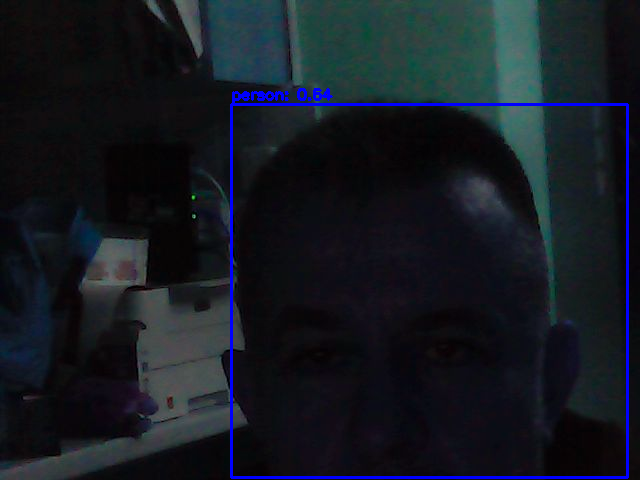

In [11]:

!pip install fastapi
!pip install kaleido
!pip install python-multipart
!pip install uvicorn
!pip install -U lida
!pip install -U torch torchvision cython
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt
import torch
!pip install -U yolov5
from yolov5.models.yolo import Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True).to(device)
model.eval()
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
  ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename
image_path = take_photo()
def preprocess_image(image_path):
    image = Image.open(image_path)
    image_tensor = F.to_tensor(image)
    return image_tensor.unsqueeze(0).to(device)
image_tensor = preprocess_image(image_path)
outputs = model(image_tensor)[0]
def draw_boxes(image_path, outputs, threshold=0.3):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    for box in outputs:
        score, label, x1, y1, x2, y2 = box[4].item(), int(box[5].item()), box[0].item(), box[1].item(), box[2].item(), box[3].item()
        if score > threshold:
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
            text = f"{model.names[label]:s}: {score:.2f}"
            cv2.putText(image, text, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    return image
from yolov5.utils.general import non_max_suppression
image_tensor = preprocess_image(image_path)
outputs = model(image_tensor)
outputs = non_max_suppression(outputs)[0]
result_image = draw_boxes(image_path, outputs)
cv2_imshow(result_image)